> Code to accompany **Chapter 5: The Principles of Adversarial Input**

# Visualising Saliency for Fashion-NMIST

To run this the notebook, you need to install a dependency that has not been released to PiPy as follows:

`pip install git+https://github.com/raghakot/keras-vis.git -U`

This avoids the bug described here: [keras-vis/issues/158](https://github.com/raghakot/keras-vis/issues/158). 

## Import the pre-trained Fashion-NMIST model

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# model = tf.keras.models.load_model('../models/fashion-MNIST.h5')

Our Fashion-MNIST classifier needs to take a channel dimension for it to work with the saliency visualisation. We'll add an extra channel dimension to the ```test_images```, ```train_images``` array so that they are in the correct format for the saliency visualization.

Each image is converted from ```[rows][columns]``` to ```[rows][columns][channels]``` where ```channels``` in this monochrome case is a single dimension. We put the channels at the end if the data format is ```channels_last``` and at the front if the format is ```channels_first```.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images/255.0
test_images = test_images/255.00


data_format = keras.backend.image_data_format()
print(data_format)
img_rows, img_cols = 28, 28

if data_format == 'channels_first':
    train_images = train_images.reshape(train_images.shape[0], 1, img_rows, img_cols)
    test_images = test_images.reshape(test_images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
    test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

channels_last


Create and train the model according to this new format

In [3]:
shape = input_shape
model = keras.Sequential([keras.layers.Flatten(input_shape=shape),
                          keras.layers.Dense(56, activation='relu'),
                          keras.layers.Dense(56, activation='relu'),
                          keras.layers.Dense(10, activation='softmax', name='predictions_layer')
                         ])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=6)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/6
60000/60000 [==============================] - 7s 110us/sample - loss: 0.5131 - acc: 0.8196
Epoch 2/6
60000/60000 [==============================] - 6s 99us/sample - loss: 0.3813 - acc: 0.8629
Epoch 3/6
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3448 - acc: 0.8738
Epoch 4/6
60000/60000 [==============================] - 6s 92us/sample - loss: 0.3212 - acc: 0.8813
Epoch 5/6
60000/60000 [==============================] - 7s 112us/sample - loss: 0.3056 - acc: 0.8871
Epoch 6/6
60000/60000 [==============================] - 7s 110us/sample - loss: 0.2910 - acc: 0.8935


Get predictions for the test data

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

predictions = model.predict(test_images)

## Visualise Saliency using Keras-vis 

The gradients are extracted based on the output logits (returned prior to the softmax layer). The following code gets this output layer from the ResNet50 model.

Note that the following code:
```
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
```
provides a workaround for the issue documented here:
https://github.com/raghakot/keras-vis/issues/160

This problem occurs because we are using the TensorFlow version of Keras and Keras-vis uses the non tensorflow version. This causes an incompatibility error when loading a model that includes an optimizer.

In [5]:
from vis.utils import utils
from keras import activations
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    layer_idx = utils.find_layer_idx(model, 'predictions_layer')
    model.layers[layer_idx].activation = activations.linear
    model = utils.apply_modifications(model)

Using TensorFlow backend.


Instructions for updating:
Use tf.cast instead.


## Printing saliency for a single image

In [7]:
from vis.visualization import visualize_saliency

image_num = 2


image = test_images[image_num]
label = np.argmax(predictions[image_num])
expected_label = test_labels[image_num]

print(test_images.shape)

print(image.shape)
print(label)

grads = visualize_saliency(model, 
                           layer_idx, 
                           filter_indices=label, 
                           seed_input=image)

print(grads.shape)

(10000, 28, 28, 1)
(28, 28, 1)
1
(28, 28)


(28, 28, 1)
(28, 28)


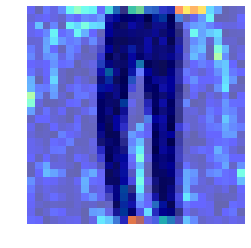

In [9]:
import matplotlib.pyplot as plt

print(image.shape)
print(grads.shape)
plt.imshow(image[..., 0], cmap=plt.cm.binary)
plt.imshow(grads, alpha=.6, cmap='jet')
plt.axis('off')
plt.show()

## Saliency maps for multiple images

In [10]:
def get_threshold(gradients, num_values):
    flattened = grads.flatten()
    flattened[::-1].sort()
    return flattened[num_values - 1]


[========================================================================] 100%


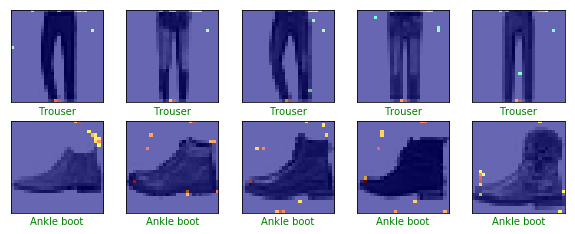

In [14]:
import progressbar

plt.figure(figsize=(10,20))

bar = progressbar.ProgressBar(maxval=20, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
row = 0
bar.start()
for current_class in [1,9]:
    bar.update(current_class)
    number_so_far = 0
    i = 0
    while number_so_far < 5:
        predicted_label = np.argmax(predictions[i])
        if predicted_label == current_class:
            number_so_far += 1
            true_label = test_labels[i]
            img = test_images[i]
            grads = visualize_saliency(model, layer_idx, filter_indices=predicted_label, seed_input=img)
            
            thresh = get_threshold(grads, top_salient_pixels)
            sub_threshold_indices = grads < thresh
            grads[sub_threshold_indices] = 0
        
            plt.subplot(10,5,number_so_far+(row*5))
            plt.xticks([])
            plt.yticks([])
            plt.grid('off')
            plt.imshow(img[..., 0], cmap=plt.cm.binary)
            plt.imshow(grads, alpha=.6, cmap='jet')
            if predicted_label == true_label:
                color = 'green'
            else:
                color = 'red'
            plt.xlabel("{}".format(class_names[predicted_label]),
                                  #class_names[true_label]),
                                  color=color)
        i += 1
    row +=1


bar.finish()
plt.savefig("ch5_code_saliency_mnist.pdf", )

C:\Users\katyw\Anaconda3\envs\strengthening-dnns\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


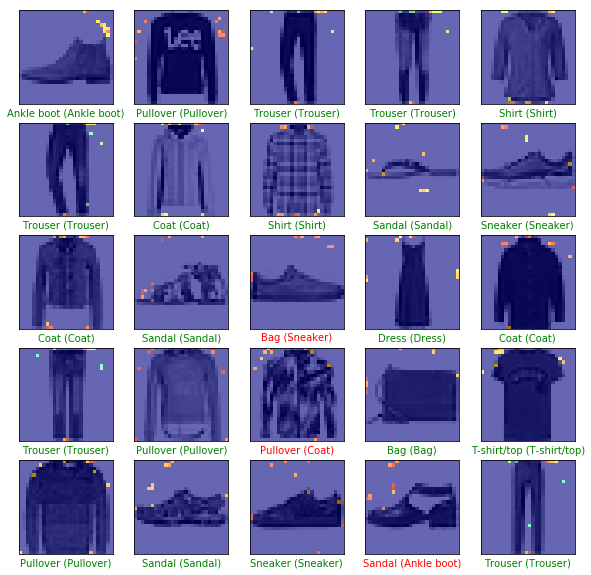

In [11]:
plt.figure(figsize=(10,10))
top_salient_pixels = 10

for i in range(25):
    image= test_images[i]
    label = np.argmax(predictions[i])
    true_label = test_labels[i]
    grads = visualize_saliency(model, 
                               layer_idx, 
                               filter_indices=label, 
                               seed_input=image)
    
    
    thresh = get_threshold(grads, top_salient_pixels)
    sub_threshold_indices = grads < thresh
    grads[sub_threshold_indices] = 0
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(image[..., 0], cmap=plt.cm.binary)
    plt.imshow(grads, alpha=.6, cmap='jet')
    if label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("{} ({})".format(class_names[label], 
                                  class_names[true_label]),
                                  color=color)